In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



In [2]:
df = pd.read_excel('marketing_campaign.xlsx')

In [3]:
# Check for exact row duplicates
duplicate_count = df.duplicated().sum()
print(f"Number of exact duplicate rows: {duplicate_count}")

# Check for ID duplicates (different rows claiming to be the same person)
id_duplicates = df.duplicated(subset=['ID']).sum()
print(f"Number of duplicate IDs: {id_duplicates}")

# Remove duplicates (if any exist)
if duplicate_count > 0 or id_duplicates > 0:
    df = df.drop_duplicates(subset=['ID'], keep='first')
    print("Duplicates removed. Keeping the first occurrence.")

Number of exact duplicate rows: 0
Number of duplicate IDs: 0


In [4]:
# 1. Handle missing values
df['Income'] = df['Income'].fillna(df['Income'].median())

# 2. Drop zero-variance columns (Columns that don't change)
df.drop(columns=['Z_CostContact', 'Z_Revenue'], inplace=True, errors='ignore')

# 3. Format dates for time-based analysis
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

In [5]:
# Calculate Customer Age
df['Age'] = 2024 - df['Year_Birth']

# Aggregate Total Spending across all 6 product categories
spend_cats = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Total_Spending'] = df[spend_cats].sum(axis=1)

# Simplify Family Structure
df['Children'] = df['Kidhome'] + df['Teenhome']
df['Is_Parent'] = np.where(df['Children'] > 0, 1, 0)

# Engagement Score (How many previous campaigns did they say 'Yes' to?)
campaigns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df['Total_Campaigns_Accepted'] = df[campaigns].sum(axis=1)

In [6]:
df = df[df['Age'] < 100]
df = df[df['Income'] < 200000]

In [7]:
# Group Marital Status into 'Partner' vs 'Alone'
df['Living_Status'] = df['Marital_Status'].replace({
    'Married': 'Partner', 'Together': 'Partner',
    'Absurd': 'Alone', 'Widow': 'Alone', 'YOLO': 'Alone', 
    'Divorced': 'Alone', 'Single': 'Alone', 'Alone': 'Alone'
})

# Encode Education to numbers (Graduation=1, PhD=2, etc.) for Correlation Matrix
le = LabelEncoder()
df['Education_Level'] = le.fit_transform(df['Education'])

Text(0.5, 1.0, 'Distribution of Customer Age')

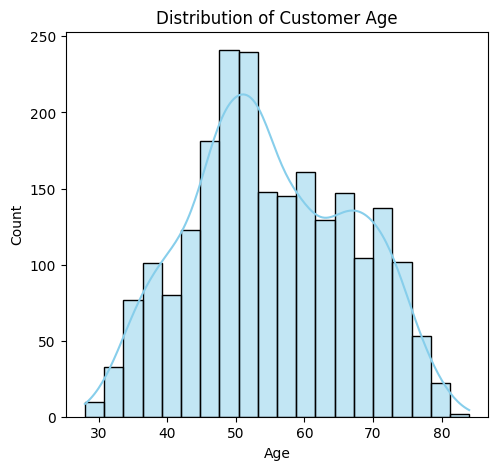

In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Age'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Customer Age')

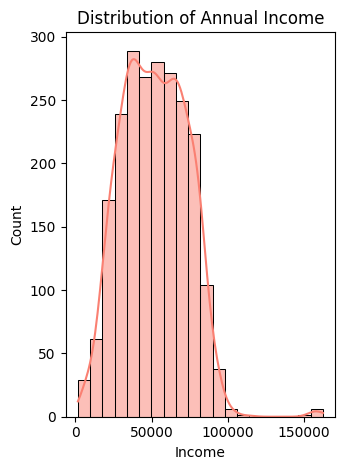

In [9]:
plt.subplot(1, 2, 2)
sns.histplot(df['Income'], bins=20, kde=True, color='salmon')
plt.title('Distribution of Annual Income')
plt.tight_layout()
plt.savefig('univariate_dist.png')

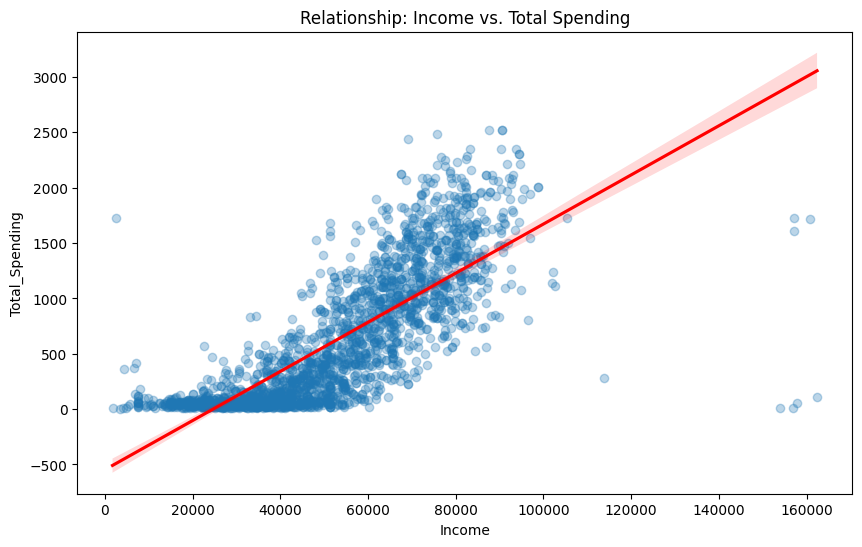

In [10]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='Income', y='Total_Spending', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Relationship: Income vs. Total Spending')
plt.savefig('income_vs_spending.png')

C:\Users\Nethma Karunarathne\AppData\Local\Temp\ipykernel_35532\2226580822.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Children', y='Total_Spending', palette='Set2')


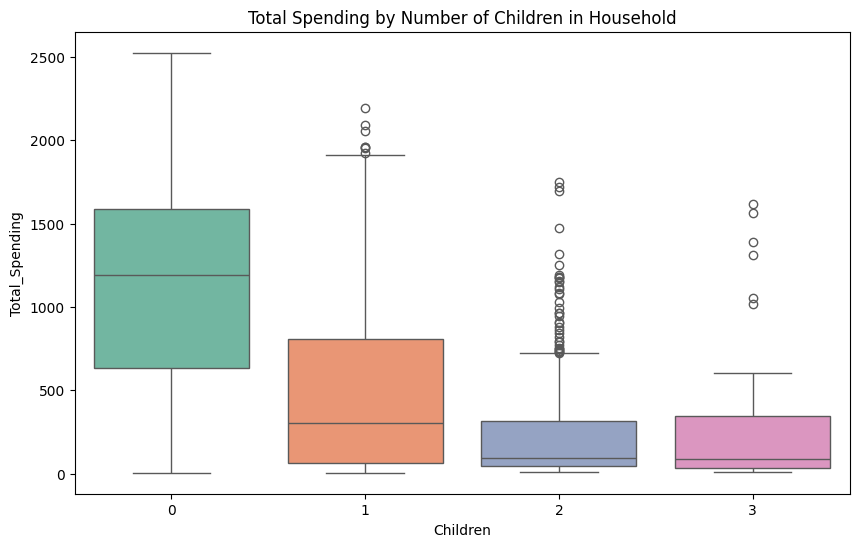

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Children', y='Total_Spending', palette='Set2')
plt.title('Total Spending by Number of Children in Household')
plt.savefig('spending_by_children.png')

C:\Users\Nethma Karunarathne\AppData\Local\Temp\ipykernel_35532\1586080384.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=melted_spend, x='Category', y='Amount', estimator=np.mean, palette='viridis')


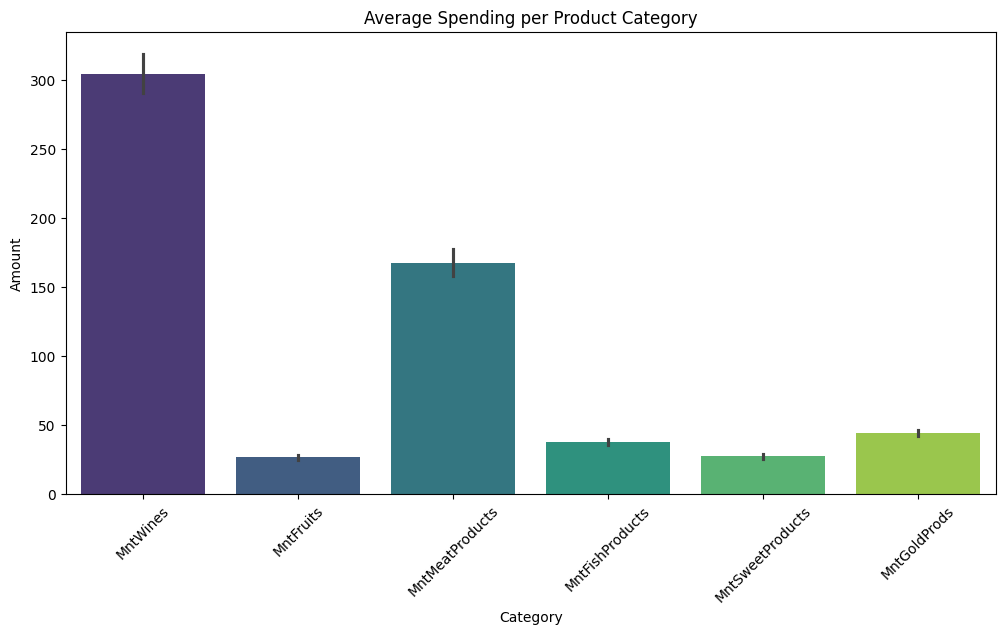

In [12]:
melted_spend = df.melt(id_vars=['ID'], value_vars=spend_cats, var_name='Category', value_name='Amount')
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_spend, x='Category', y='Amount', estimator=np.mean, palette='viridis')
plt.title('Average Spending per Product Category')
plt.xticks(rotation=45)
plt.savefig('category_spending.png')

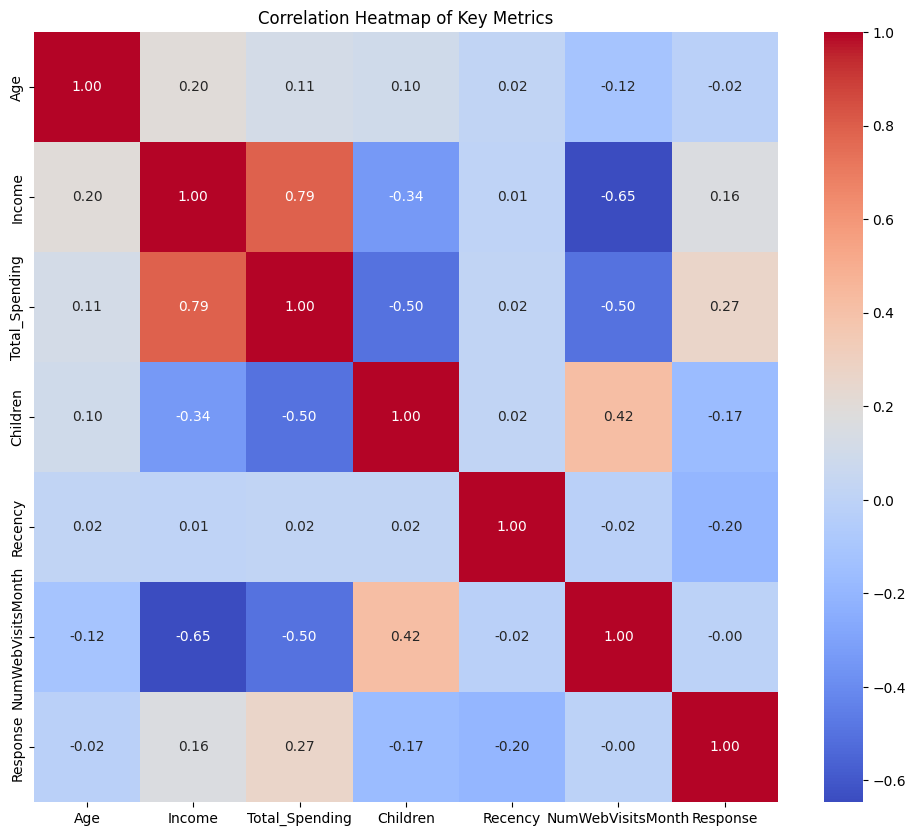

In [13]:
plt.figure(figsize=(12, 10))
corr_cols = ['Age', 'Income', 'Total_Spending', 'Children', 'Recency', 'NumWebVisitsMonth', 'Response']
correlation_matrix = df[corr_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Key Metrics')
plt.savefig('correlation_heatmap.png')

C:\Users\Nethma Karunarathne\AppData\Local\Temp\ipykernel_35532\3752707860.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=campaign_success.index, y=campaign_success.values, palette='magma')


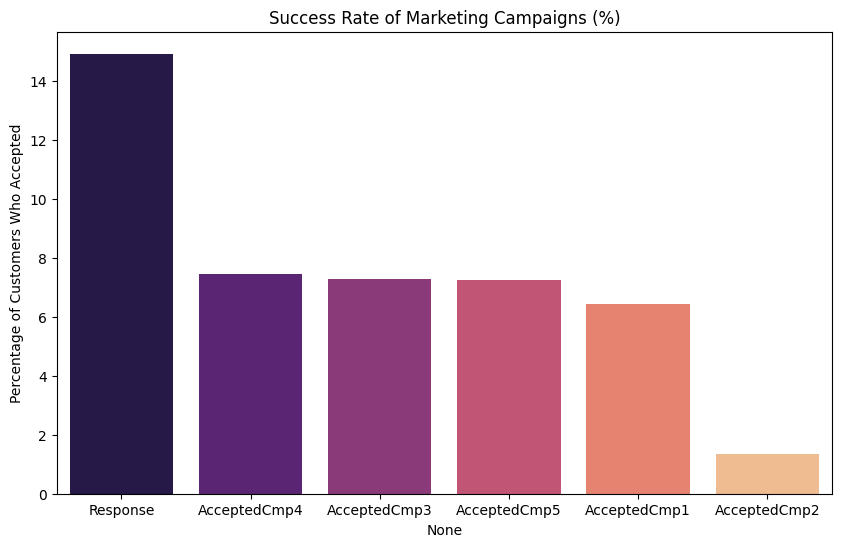

In [14]:
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
campaign_success = df[campaign_cols].mean().sort_values(ascending=False) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=campaign_success.index, y=campaign_success.values, palette='magma')
plt.title('Success Rate of Marketing Campaigns (%)')
plt.ylabel('Percentage of Customers Who Accepted')
plt.savefig('campaign_success_rates.png')

In [15]:
metrics_to_compare = ['Income', 'Total_Spending', 'Recency', 'NumWebVisitsMonth']
comparison = df.groupby('Response')[metrics_to_compare].mean()

print("Responders vs Non-Responders Mean Metrics:")
print(comparison)

Responders vs Non-Responders Mean Metrics:
                Income  Total_Spending    Recency  NumWebVisitsMonth
Response                                                            
0         50507.277340      539.009989  51.527865           5.323344
1         60183.244012      987.392216  35.383234           5.293413


C:\Users\Nethma Karunarathne\AppData\Local\Temp\ipykernel_35532\2706651624.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Response', y='Total_Spending', palette='Set1')


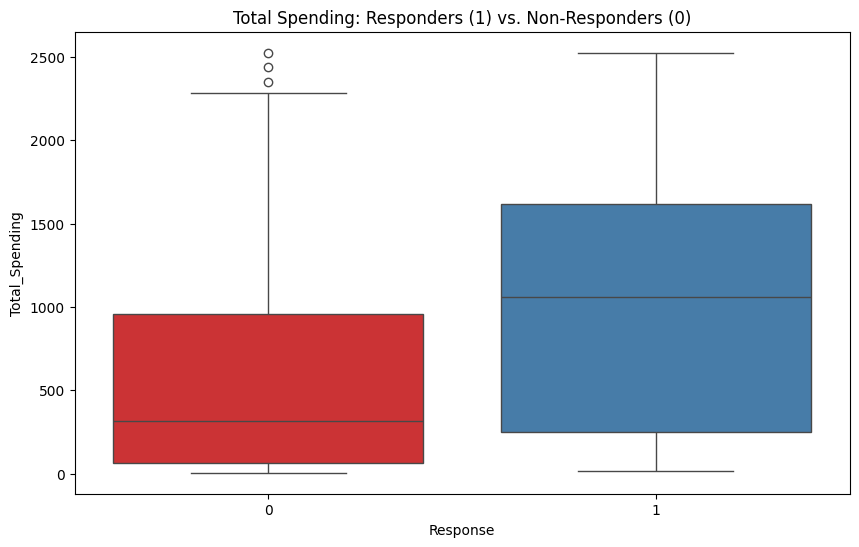

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Response', y='Total_Spending', palette='Set1')
plt.title('Total Spending: Responders (1) vs. Non-Responders (0)')
plt.savefig('spending_by_response.png')

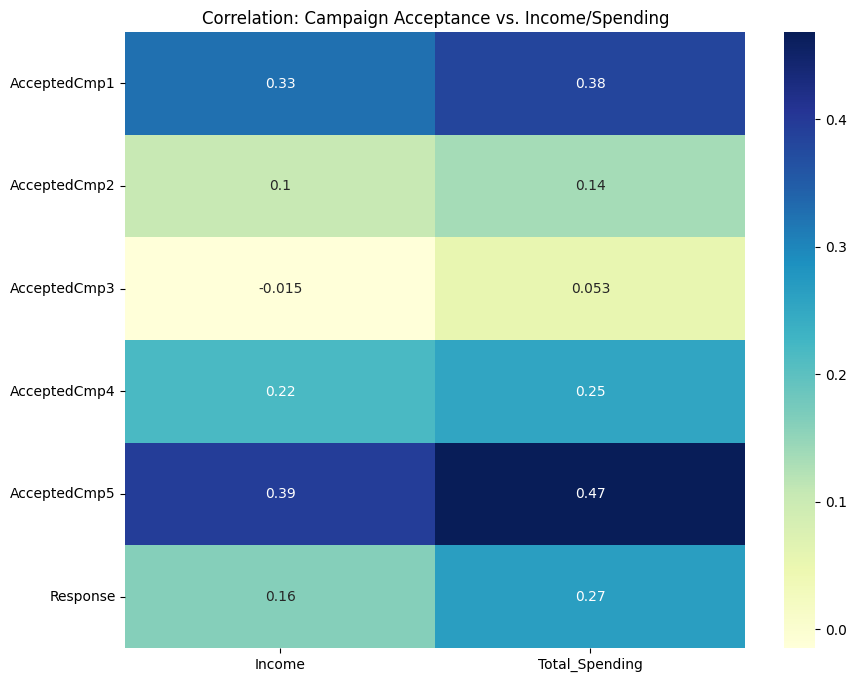

In [17]:
campaign_corr = df[campaign_cols + ['Income', 'Total_Spending']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(campaign_corr.loc[campaign_cols, ['Income', 'Total_Spending']], annot=True, cmap='YlGnBu')
plt.title('Correlation: Campaign Acceptance vs. Income/Spending')
plt.savefig('campaign_correlation.png')

In [18]:
df['Total_Accepted_Cmp'] = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)
loyalty_spend = df.groupby('Total_Accepted_Cmp')['Total_Spending'].mean()

print("\nAverage Spending by Number of Campaigns Accepted:")
print(loyalty_spend)


Average Spending by Number of Campaigns Accepted:
Total_Accepted_Cmp
0     478.529312
1     918.645062
2    1408.048193
3    1705.636364
4    1501.636364
Name: Total_Spending, dtype: float64


In [19]:
# Calculate and print formatted values
comparison = df.groupby('Response')[['Income', 'Total_Spending', 'Recency', 'Children']].mean().round(1)

print(f"Income - Responders: ${comparison.loc[1, 'Income']:,.0f}, Non-Responders: ${comparison.loc[0, 'Income']:,.0f}")
print(f"Total Spending - Responders: ${comparison.loc[1, 'Total_Spending']:,.0f}, Non-Responders: ${comparison.loc[0, 'Total_Spending']:,.0f}")
print(f"Recency - Responders: {comparison.loc[1, 'Recency']:.0f} days, Non-Responders: {comparison.loc[0, 'Recency']:.0f} days")
print(f"Children - Responders: {comparison.loc[1, 'Children']:.1f}, Non-Responders: {comparison.loc[0, 'Children']:.1f}")

Income - Responders: $60,183, Non-Responders: $50,507
Total Spending - Responders: $987, Non-Responders: $539
Recency - Responders: 35 days, Non-Responders: 52 days
Children - Responders: 0.6, Non-Responders: 1.0


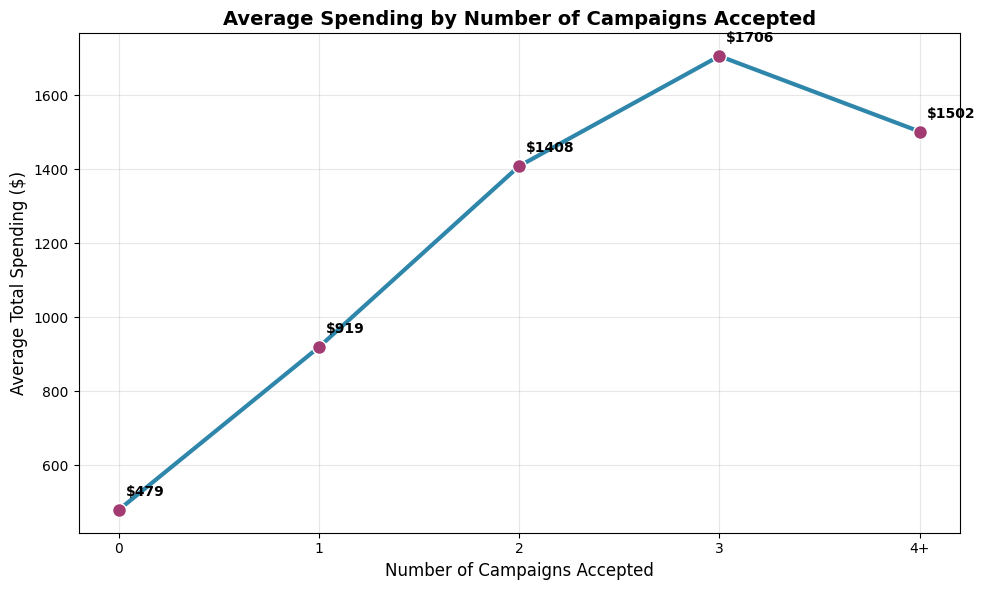

In [20]:
# Line chart for loyalty spending trend
plt.figure(figsize=(10, 6))

plt.plot(loyalty_spend.index, loyalty_spend.values, marker='o', markersize=10, 
         linewidth=3, color='#2E86AB', markerfacecolor='#A23B72', markeredgecolor='white')

# Add value labels
for i, v in enumerate(loyalty_spend.values):
    plt.annotate(f'${v:.0f}', (loyalty_spend.index[i], v), 
                xytext=(5, 10), textcoords='offset points', fontsize=10, fontweight='bold')

plt.title('Average Spending by Number of Campaigns Accepted', fontsize=14, fontweight='bold')
plt.xlabel('Number of Campaigns Accepted', fontsize=12)
plt.ylabel('Average Total Spending ($)', fontsize=12)
plt.xticks(range(5), ['0', '1', '2', '3', '4+'])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('loyalty_spending_line.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Nethma Karunarathne\AppData\Local\Temp\ipykernel_35532\1467538376.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_spending = df.groupby('Age_Group')['Total_Spending'].agg(['mean', 'count', 'std']).round(1)
C:\Users\Nethma Karunarathne\AppData\Local\Temp\ipykernel_35532\1467538376.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=age_spending.index, y=age_spending['mean'], palette='viridis')


Average Spending by Age Group:
            mean  count    std
Age_Group                     
18-30      563.4      7  663.1
31-40      610.6    214  695.4
41-50      520.4    556  590.8
51-60      554.4    676  581.2
60+        710.4    783  585.2


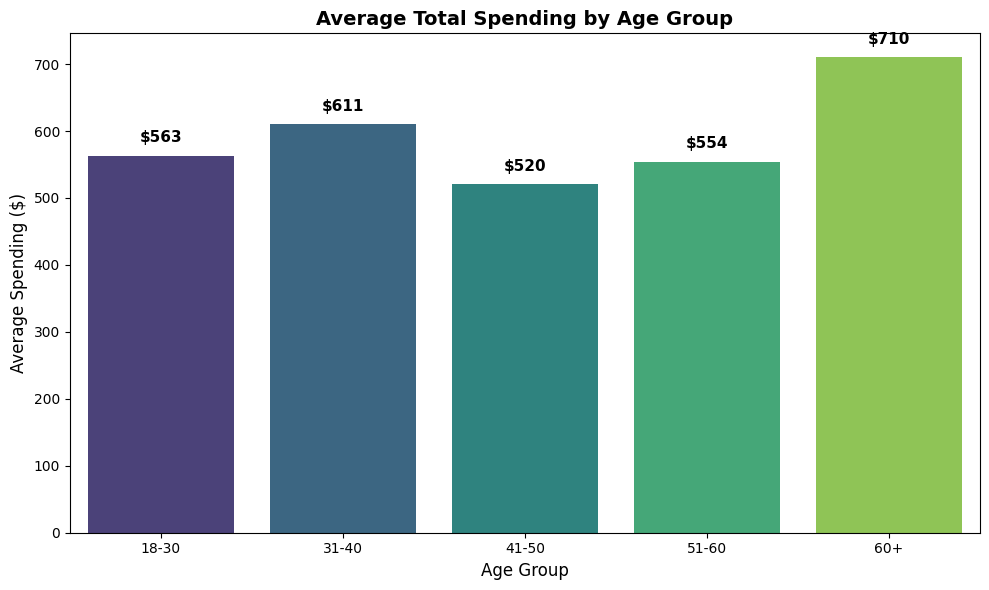

In [21]:
# Create age groups/bins
bins = [18, 30, 40, 50, 60, 100]
labels = ['18-30', '31-40', '41-50', '51-60', '60+']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Calculate average spending by age group
age_spending = df.groupby('Age_Group')['Total_Spending'].agg(['mean', 'count', 'std']).round(1)
print("Average Spending by Age Group:")
print(age_spending)

# Bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=age_spending.index, y=age_spending['mean'], palette='viridis')
plt.title('Average Total Spending by Age Group', fontsize=14, fontweight='bold')
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Average Spending ($)', fontsize=12)

# Add value labels
for i, v in enumerate(age_spending['mean']):
    ax.text(i, v + 20, f'${v:.0f}', ha='center', fontsize=11, fontweight='bold')
    
plt.tight_layout()
plt.savefig('spending_by_age.png', dpi=300, bbox_inches='tight')
plt.show()

Features Correlated with Campaign Response:
Response             1.000000
AcceptedCmp5         0.328148
AcceptedCmp1         0.293849
Total_Spending       0.265615
AcceptedCmp3         0.254106
AcceptedCmp4         0.176847
AcceptedCmp2         0.169234
Income               0.161121
NumWebVisitsMonth   -0.004397
Age                 -0.018557
Children            -0.169451
Recency             -0.198781
Name: Response, dtype: float64


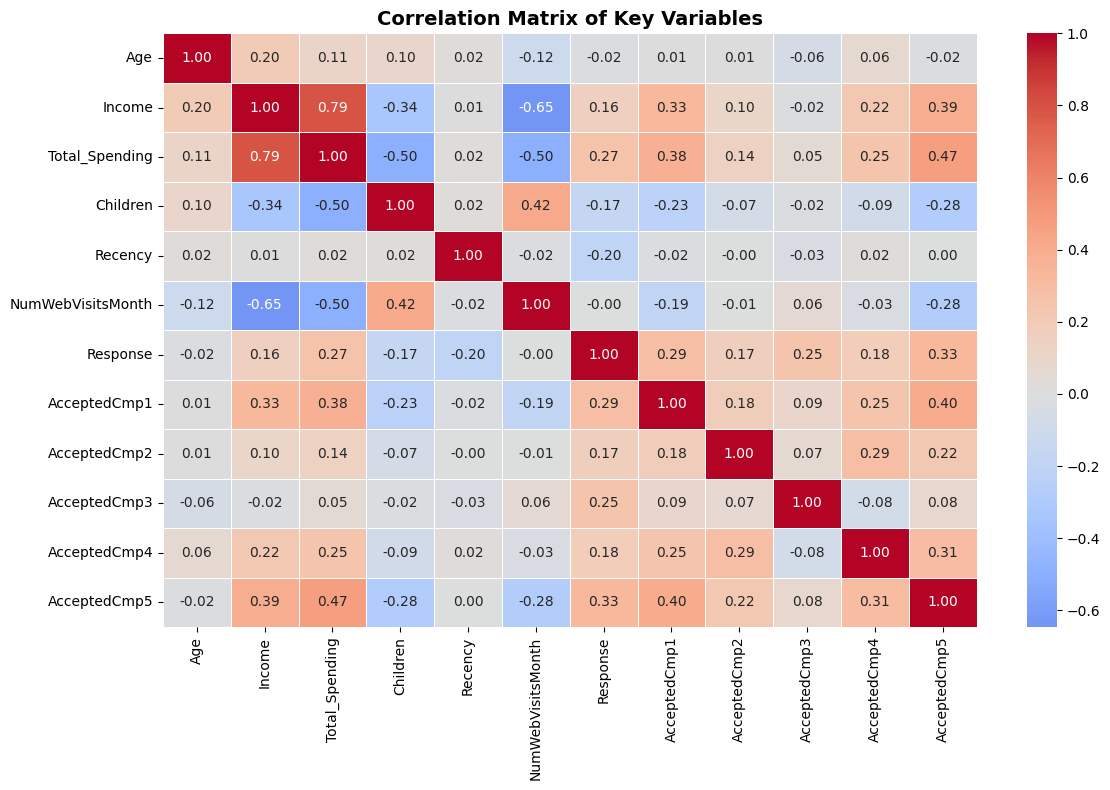

In [22]:
# Comprehensive correlation analysis
# Select relevant numerical columns
numeric_cols = ['Age', 'Income', 'Total_Spending', 'Children', 'Recency', 
                'NumWebVisitsMonth', 'Response', 'AcceptedCmp1', 'AcceptedCmp2', 
                'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']

correlation_matrix = df[numeric_cols].corr()

# Focus on correlations with Response
response_corr = correlation_matrix['Response'].sort_values(ascending=False)
print("Features Correlated with Campaign Response:")
print(response_corr)

# Visualize
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Key Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('full_correlation_matrix.png', dpi=300)
plt.show()

Logistic Regression Results:

Classification Report:
               precision    recall  f1-score   support

Non-Responder       0.94      0.78      0.85       571
    Responder       0.35      0.70      0.47       100

     accuracy                           0.76       671
    macro avg       0.65      0.74      0.66       671
 weighted avg       0.85      0.76      0.79       671


Confusion Matrix:
[[443 128]
 [ 30  70]]

ROC-AUC Score: 0.834

Feature Importance (Top 10):
                 Feature  Coefficient  Odds_Ratio
1         Total_Spending     1.060206    2.886966
5      NumWebVisitsMonth     0.861453    2.366598
7        MntMeatProducts     0.171781    1.187418
8        Education_Level     0.118930    1.126291
12         Education_PhD     0.111850    1.118345
11      Education_Master     0.040796    1.041640
0                 Income     0.014251    1.014353
10  Education_Graduation    -0.071137    0.931334
4                    Age    -0.120600    0.886388
9        Education_B

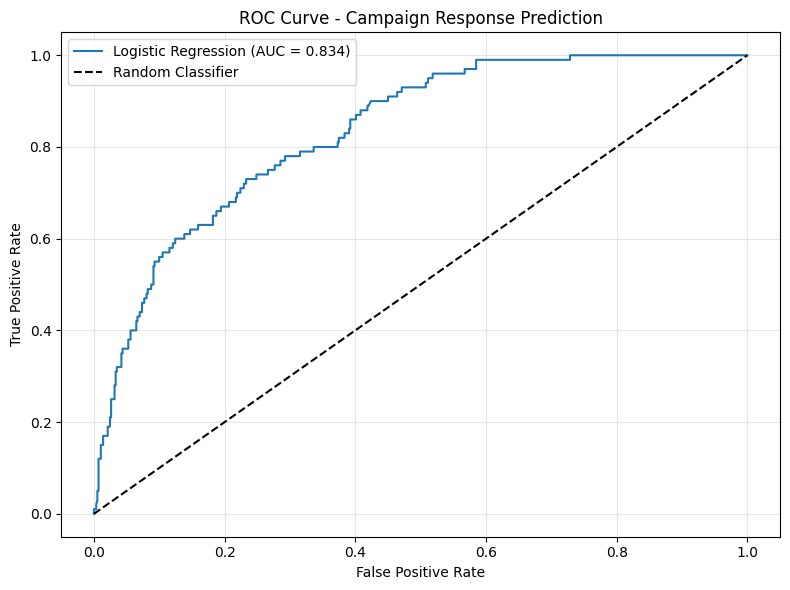

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

# Prepare features for prediction
feature_cols = ['Income', 'Total_Spending', 'Recency', 'Children', 'Age', 
                'NumWebVisitsMonth', 'MntWines', 'MntMeatProducts']

# Create dummy variables for categorical features
df_encoded = pd.get_dummies(df, columns=['Education', 'Living_Status'], drop_first=True)

# Add encoded columns to features
encoded_cols = [col for col in df_encoded.columns if 'Education_' in col or 'Living_Status_' in col]
feature_cols.extend(encoded_cols)

# Prepare X and y
X = df_encoded[feature_cols]
y = df_encoded['Response']

# Handle any missing values
X = X.fillna(X.median())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Logistic Regression Results:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Responder', 'Responder']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.3f}")

# Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': log_reg.coef_[0],
    'Odds_Ratio': np.exp(log_reg.coef_[0])
}).sort_values('Coefficient', ascending=False)

print("\nFeature Importance (Top 10):")
print(feature_importance.head(10))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Campaign Response Prediction')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

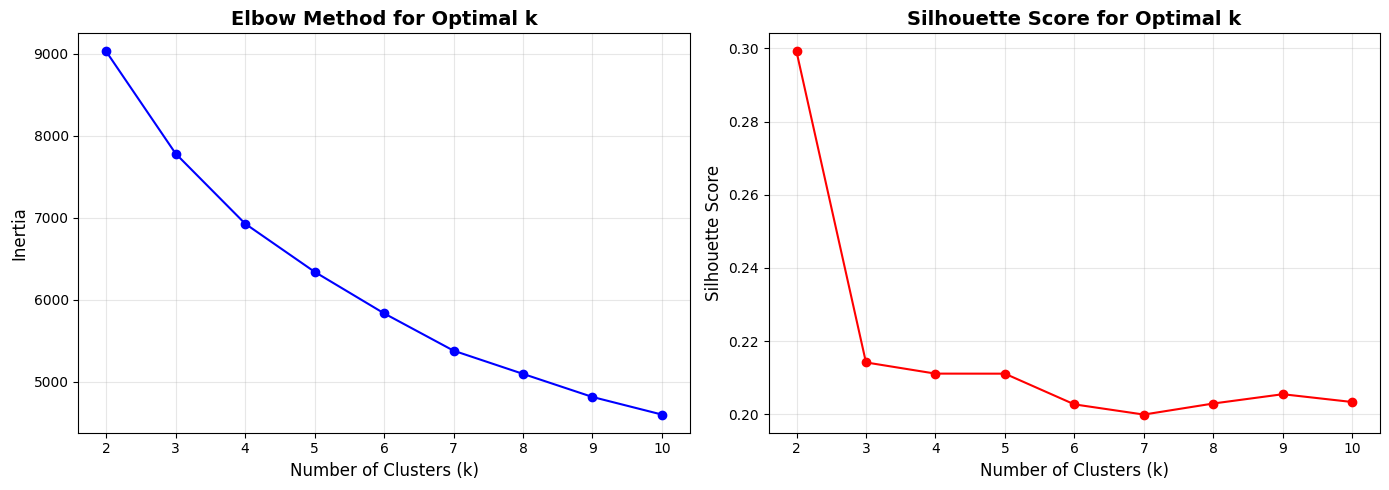


Customer Segment Profiles:
         Avg_Income  Avg_Spending  Avg_Age  Avg_Children  Avg_Recency  \
Cluster                                                                 
2           78789.6        1418.2     54.6           0.1         50.1   
1           59102.8         745.7     61.5           0.9         48.3   
3           42664.5         190.0     58.7           2.1         50.2   
0           30598.9         128.8     46.5           0.8         48.5   

         Avg_WebVisits  Response_Rate  Count  Percentage  
Cluster                                                   
2                  2.4           30.0    491        22.0  
1                  5.2           10.0    660        29.5  
3                  6.4           10.0    437        19.5  
0                  7.0           10.0    648        29.0  


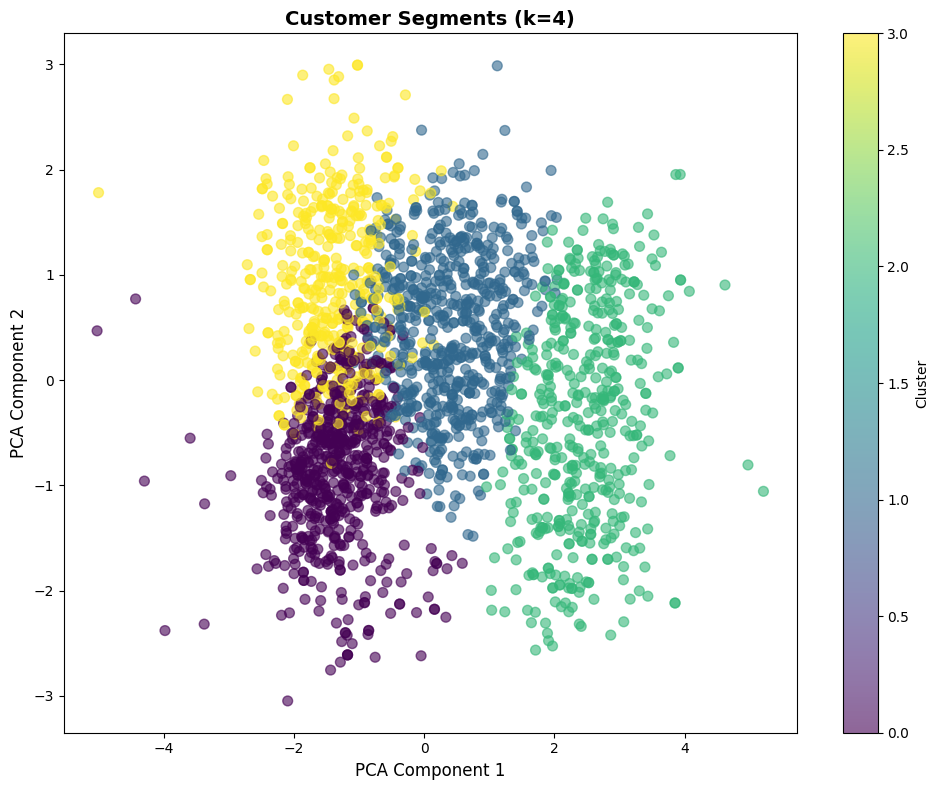

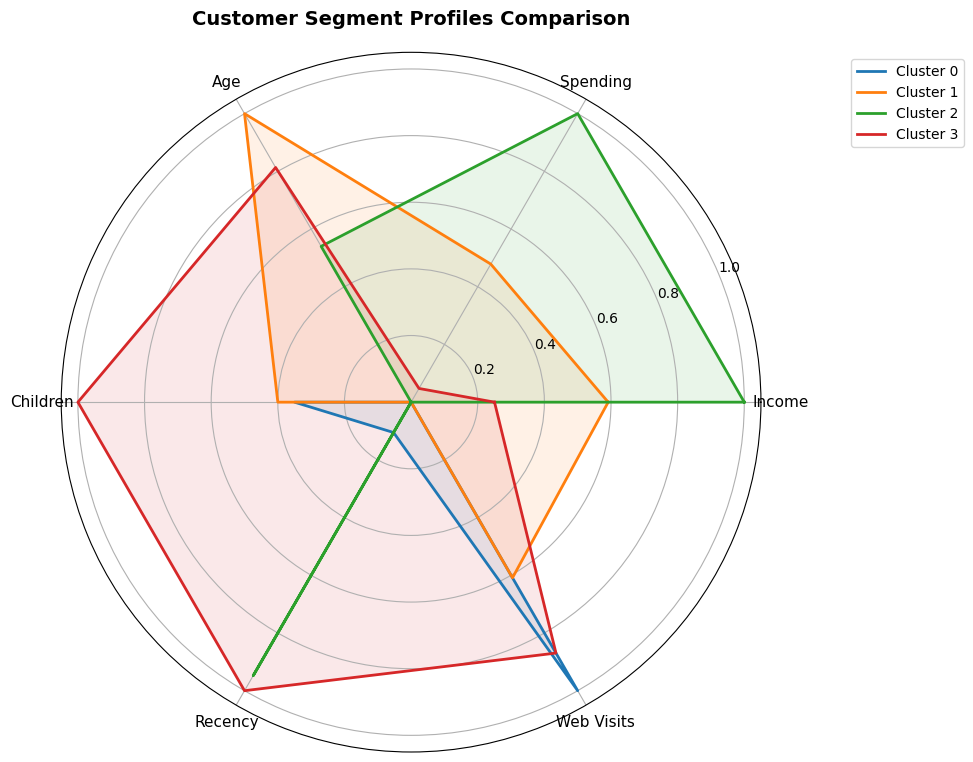

In [24]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select features for clustering
cluster_features = ['Income', 'Total_Spending', 'Age', 'Children', 'Recency', 'NumWebVisitsMonth']
cluster_df = df[cluster_features].copy()

# Handle missing values
cluster_df = cluster_df.fillna(cluster_df.median())

# Scale features
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_df)

# Find optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(cluster_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(cluster_scaled, kmeans.labels_))

# Plot elbow curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia', fontsize=12)
ax1.set_title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score for Optimal k', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('elbow_method.png', dpi=300)
plt.show()

# Choose optimal k (likely 4 based on your data)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(cluster_scaled)

# Analyze clusters
cluster_profile = df.groupby('Cluster').agg({
    'Income': 'mean',
    'Total_Spending': 'mean',
    'Age': 'mean',
    'Children': 'mean',
    'Recency': 'mean',
    'NumWebVisitsMonth': 'mean',
    'Response': 'mean',
    'ID': 'count'
}).round(1)

cluster_profile.columns = ['Avg_Income', 'Avg_Spending', 'Avg_Age', 'Avg_Children', 
                           'Avg_Recency', 'Avg_WebVisits', 'Response_Rate', 'Count']
cluster_profile['Response_Rate'] = (cluster_profile['Response_Rate'] * 100).round(1)
cluster_profile['Percentage'] = (cluster_profile['Count'] / cluster_profile['Count'].sum() * 100).round(1)

print("\nCustomer Segment Profiles:")
print(cluster_profile.sort_values('Avg_Spending', ascending=False))

# Visualize clusters using PCA
pca = PCA(n_components=2)
cluster_pca = pca.fit_transform(cluster_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(cluster_pca[:, 0], cluster_pca[:, 1], 
                      c=df['Cluster'], cmap='viridis', alpha=0.6, s=50)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.title(f'Customer Segments (k={optimal_k})', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.savefig('clusters_pca.png', dpi=300)
plt.show()

# Radar chart for cluster comparison
from math import pi

# Normalize cluster profiles for radar chart
cluster_radar = cluster_profile[['Avg_Income', 'Avg_Spending', 'Avg_Age', 
                                  'Avg_Children', 'Avg_Recency', 'Avg_WebVisits']].copy()

# Normalize each column to 0-1 range
for col in cluster_radar.columns:
    cluster_radar[col] = (cluster_radar[col] - cluster_radar[col].min()) / (cluster_radar[col].max() - cluster_radar[col].min())

# Radar chart
categories = ['Income', 'Spending', 'Age', 'Children', 'Recency', 'Web Visits']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for i in range(optimal_k):
    values = cluster_radar.iloc[i].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_title('Customer Segment Profiles Comparison', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.tight_layout()
plt.savefig('cluster_radar.png', dpi=300)
plt.show()